<a href="https://colab.research.google.com/github/miltiadiss/CEID_NE577-5G-Architectures-Technologies-Applications-and-Key-Performance-Indexes/blob/main/Code/Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**LIBRARIES**

In [83]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import scipy.stats as stats
import math
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import warnings
warnings.filterwarnings("ignore")

# **PREPROCESSING AND DATASET EXPLORATION**

Fisrt, we load the dataset, remove dublicates and unecessary columns. Also add 'scenario' column that corresponds to the movement type (trace) of the device.

In [68]:
data_dir = "/content/drive/MyDrive/Dataset"

# Movement scenarios
scenarios = ["train", "pedestrian", "static", "car", "bus"]

# Define the string columns
string_columns = ["State", "NetworkMode", "Operatorname", "Timestamp"]

# Initialize the list that stores the DataFrames
trace_dataframes = []

# Iterate every movemement scenario (trace)
for scenario in scenarios:
    scenario_path = os.path.join(data_dir, scenario)

    if os.path.exists(scenario_path):
        for file in os.listdir(scenario_path):
            if file.endswith(".csv"):
                file_path = os.path.join(scenario_path, file)

                try:
                    # Read the corresponding csv
                    df = pd.read_csv(file_path, dtype=str)  # Keep the strings

                    if 'Timestamp' in df.columns:  # Ensure case sensitivity
                        df['Timestamp'] = df['Timestamp'].astype(str).str.strip()
                        df['Timestamp'] = df['Timestamp'].str.replace('_', ' ', regex=False)  # Replace "_" with ' '

                    # Replace "-" in numeric columns with NaN
                    for col in df.columns:
                        if col not in string_columns:
                            df[col] = df[col].replace("-", np.nan)
                            df[col] = pd.to_numeric(df[col], errors='coerce')

                    # Remove duplicates
                    df.drop_duplicates(inplace=True)

                    # Remove the columns that contain the coordinates of the mobile device and the cell
                    df.drop(columns=['Longitude', 'Latitude', 'ServingCell_Lon', 'ServingCell_Lat'], inplace=True)

                    # Add movement scenario column for each trace
                    df['scenario'] = scenario

                    # Store Dataframe in the list
                    trace_dataframes.append(df)

                except Exception as e:
                    print(f"Σφάλμα κατά την επεξεργασία του αρχείου {file_path}: {e}")

# Combine all traces in one DataFrame
if trace_dataframes:
    combined_data = pd.concat(trace_dataframes, ignore_index=True)

print(combined_data.shape)

(173692, 17)


We now sort the dataset instances based on the timestamp is ascending order to create the time series correctly.

In [69]:
# Transform 'Timestamp' into datetime format
combined_data["Timestamp"] = pd.to_datetime(combined_data["Timestamp"], format="%Y.%m.%d %H.%M.%S", errors="coerce")

# Sort DataFrame chronologically to create the time series
combined_data = combined_data.sort_values(by="Timestamp").reset_index(drop=True)

In [70]:
combined_data

,Timestamp,Speed,Operatorname,CellID,NetworkMode,RSRP,RSRQ,SNR,CQI,RSSI,DL_bitrate,UL_bitrate,State,NRxRSRP,NRxRSRQ,ServingCell_Distance,scenario
0,2017-11-21 15:03:50,0,A,2,LTE,-95,-13.0,4.0,10.0,-80.0,0,0,D,NaN,NaN,551.37,pedestrian
1,2017-11-21 15:03:51,0,A,2,LTE,-95,-13.0,2.0,8.0,-78.0,0,0,I,NaN,NaN,551.37,pedestrian
2,2017-11-21 15:03:52,0,A,2,LTE,-95,-13.0,13.0,9.0,-80.0,0,0,I,NaN,NaN,553.43,pedestrian
3,2017-11-21 15:03:53,1,A,2,LTE,-95,-13.0,13.0,9.0,-80.0,0,0,I,NaN,NaN,563.48,pedestrian
4,2017-11-21 15:03:54,1,A,2,LTE,-97,-13.0,-2.0,9.0,-80.0,0,0,I,NaN,NaN,563.48,pedestrian
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173687,2018-02-12 16:28:41,0,B,3,LTE,-104,-11.0,13.0,10.0,-83.0,40586,755,D,NaN,NaN,660.10,static
173688,2018-02-12 16:28:42,0,A,2,LTE,-106,-13.0,3.0,7.0,-90.0,4496,79,D,NaN,NaN,404.60,static
173689,2018-02-12 16:28:42,0,B,3,LTE,-104,-11.0,13.0,10.0,-83.0,49120,909,D,NaN,NaN,660.10,static
173690,2018-02-12 16:28:43,0,B,3,LTE,-100,-12.0,16.0,13.0,-81.0,59364,1194,D,NaN,NaN,660.10,static


Split into training and test set with ratio 80% and 20%. For the training of the models we will also split training set into training and validation sets.

In [71]:
# Set training set 80% of the whle dataset
train_ratio = 0.8

# Split into train and test sets
split_index = int(len(combined_data) * train_ratio)
train_df = combined_data.iloc[:split_index].reset_index(drop=True)
test_df = combined_data.iloc[split_index:].reset_index(drop=True)

In [72]:
train_df

,Timestamp,Speed,Operatorname,CellID,NetworkMode,RSRP,RSRQ,SNR,CQI,RSSI,DL_bitrate,UL_bitrate,State,NRxRSRP,NRxRSRQ,ServingCell_Distance,scenario
0,2017-11-21 15:03:50,0,A,2,LTE,-95,-13.0,4.0,10.0,-80.0,0,0,D,NaN,NaN,551.37,pedestrian
1,2017-11-21 15:03:51,0,A,2,LTE,-95,-13.0,2.0,8.0,-78.0,0,0,I,NaN,NaN,551.37,pedestrian
2,2017-11-21 15:03:52,0,A,2,LTE,-95,-13.0,13.0,9.0,-80.0,0,0,I,NaN,NaN,553.43,pedestrian
3,2017-11-21 15:03:53,1,A,2,LTE,-95,-13.0,13.0,9.0,-80.0,0,0,I,NaN,NaN,563.48,pedestrian
4,2017-11-21 15:03:54,1,A,2,LTE,-97,-13.0,-2.0,9.0,-80.0,0,0,I,NaN,NaN,563.48,pedestrian
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138948,2018-01-18 15:03:26,0,A,2,LTE,-95,-14.0,-5.0,8.0,NaN,6811,103,D,-98.0,-19.0,2911.32,car
138949,2018-01-18 15:03:26,46,B,2,LTE,-104,-15.0,-2.0,7.0,-88.0,14337,216,D,-107.0,-16.0,74022.44,car
138950,2018-01-18 15:03:27,0,A,2,LTE,-95,-14.0,-5.0,8.0,NaN,8443,142,D,-98.0,-19.0,2911.32,car
138951,2018-01-18 15:03:28,46,B,2,LTE,-104,-15.0,-2.0,7.0,-88.0,15378,256,D,-107.0,-16.0,74022.44,car


Plot the timeseries of target variable (DL_bitrate) from the training set and move on to the decomposition of the timeseries into trend, seasonability and residuals.

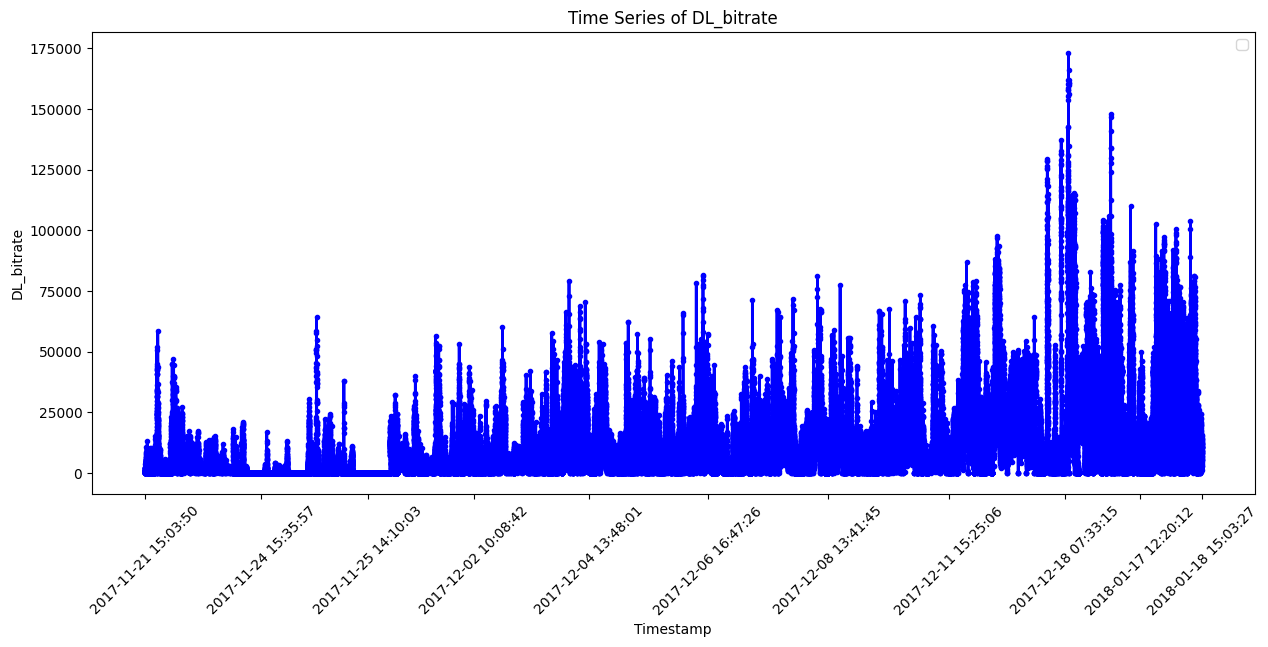

In [24]:
train_df['Timestamp'] = train_df['Timestamp'].astype(str)

# Plot the time series of DL_bitrate i training set
plt.figure(figsize=(15, 6))
plt.plot(train_df['Timestamp'], train_df['DL_bitrate'], marker='o', linestyle='-', markersize=3, color='blue', linewidth=2)
plt.xlabel("Timestamp")
plt.ylabel("DL_bitrate")
plt.title("Time Series of DL_bitrate")

plt.xticks(ticks=train_df['Timestamp'][::max(1, len(train_df) // 10)], rotation=45)

plt.legend()
plt.show()

<Figure size 1000x800 with 0 Axes>

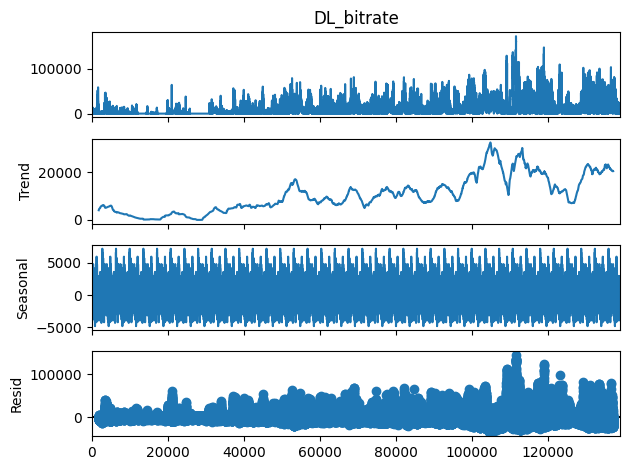

In [25]:
# Seasonal Decomposition
decomposition = seasonal_decompose(train_df['DL_bitrate'], model='additive', period=3600)  # Use period=3600 for hourly seasonality

# Plot decomposition
plt.figure(figsize=(10, 8))
decomposition.plot()
plt.show()

Calculate CV value of target variable to determine how variant and difficut to predict it is.

In [26]:
# Calculate Coefficient of Variation (CV) for DL_bitrate in training set
mean_dl = train_df['DL_bitrate'].mean()
std_dl = train_df['DL_bitrate'].std()

cv_dl = std_dl / mean_dl

print(f"Coefficient of Variation for DL_bitrate: {cv_dl:.4f}")

Coefficient of Variation for DL_bitrate: 1.3319


Check also how target is related with the other input features.

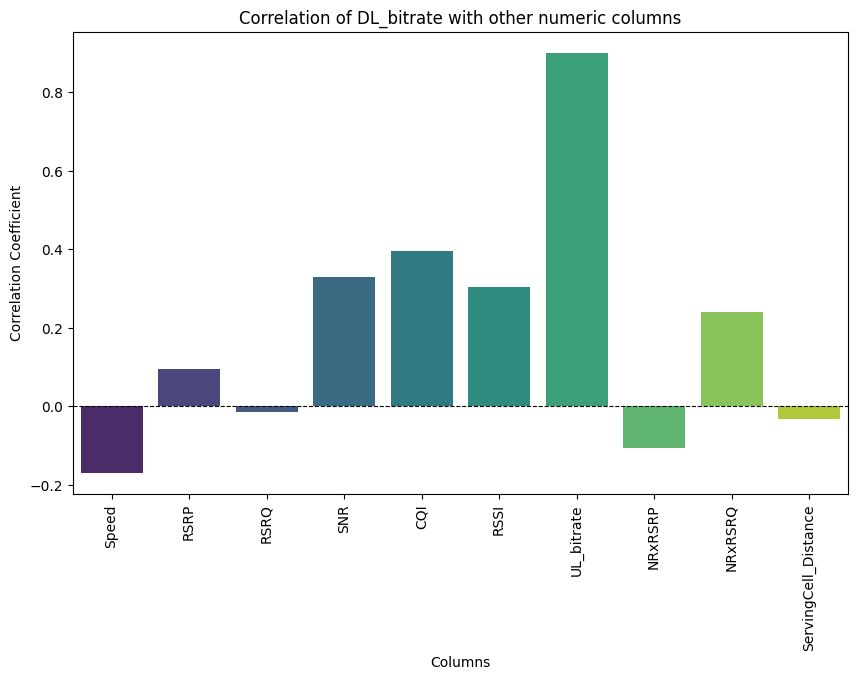

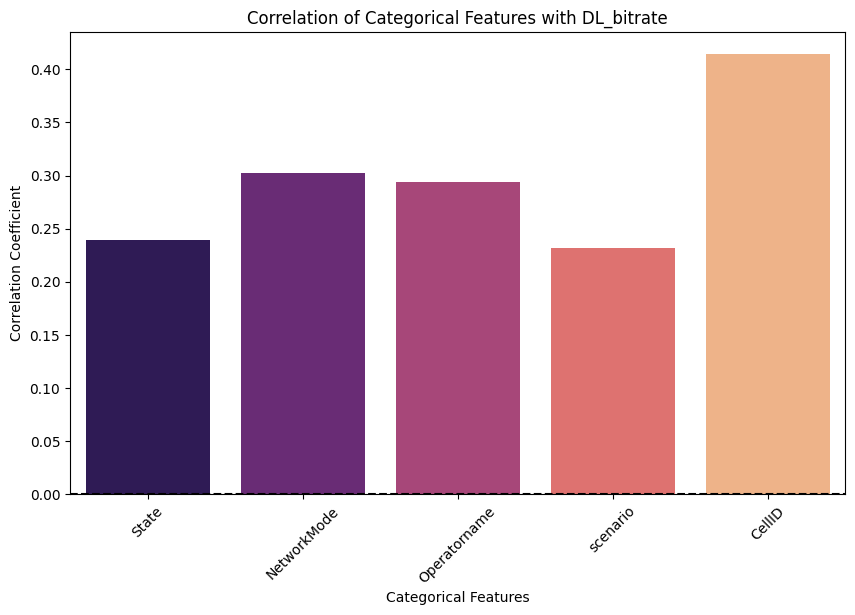

In [27]:
# Remove non-numeric columns
non_numeric_columns = ['Timestamp', 'State', 'NetworkMode', 'Operatorname', 'CellID', 'scenario']
numeric_columns = [col for col in train_df.columns if col not in non_numeric_columns]

# Calculate correlation coefficients
correlations = train_df[numeric_columns].corr(method='kendall')

# Calculate correlation with DL_bitrate
dl_bitrate_corr = correlations['DL_bitrate'].drop('DL_bitrate')

plt.figure(figsize=(10, 6))
sns.barplot(x=dl_bitrate_corr.index, y=dl_bitrate_corr.values, palette='viridis')
plt.axhline(0, color='black', linewidth=0.8, linestyle='--')
plt.title("Correlation of DL_bitrate with other numeric columns")
plt.xticks(rotation=90)
plt.ylabel("Correlation Coefficient")
plt.xlabel("Columns")
plt.show()

# Define categorical columns
categorical_columns = ['State', 'NetworkMode', 'Operatorname', 'scenario', 'CellID']

# Dictionary to store correlations
category_correlations = {}

# Compute correlation for each categorical variable
for cat_col in categorical_columns:
    # Convert categories into their mean DL_bitrate (Target Encoding)
    encoded_values = train_df.groupby(cat_col)['DL_bitrate'].transform('mean')

    # Compute Pearson correlation between encoded values and target
    correlation = np.corrcoef(encoded_values, train_df['DL_bitrate'])[0, 1]

    category_correlations[cat_col] = correlation

# Convert dictionary to DataFrame for visualization
category_corr_df = pd.DataFrame.from_dict(category_correlations, orient='index', columns=['Correlation'])

# Plot the categorical correlations as a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=category_corr_df.index, y=category_corr_df['Correlation'], palette='magma')
plt.axhline(0, color='black', linestyle='--')
plt.title("Correlation of Categorical Features with DL_bitrate")
plt.ylabel("Correlation Coefficient")
plt.xlabel("Categorical Features")
plt.xticks(rotation=45)
plt.show()

## **Numerical features**

Replace NULL values in numeric features using linear interpolation between neighboring values.



In [73]:
'''# Διόρθωση μορφής ημερομηνίας και μετατροπή σε datetime
train_df["Timestamp"] = pd.to_datetime(df["Timestamp"], format="%Y.%m.%d %H.%M.%S", errors="coerce")
test_df["Timestamp"] = pd.to_datetime(df["Timestamp"], format="%Y.%m.%d %H.%M.%S", errors="coerce")

# Ταξινόμηση του DataFrame βάσει χρονικής σειράς
train_df = train_df.sort_values(by="Timestamp").reset_index(drop=True)
test_df = test_df.sort_values(by="Timestamp").reset_index(drop=True)'''

# Replace NaN values in numeric columns with linear interpolation values
for column in numeric_columns:
    train_df[column] = train_df[column].interpolate(method='linear', limit_direction='both')
for column in numeric_columns:
    test_df[col] = test_df[col].interpolate(method='linear', limit_direction='both')

In [74]:
train_df

,Timestamp,Speed,Operatorname,CellID,NetworkMode,RSRP,RSRQ,SNR,CQI,RSSI,DL_bitrate,UL_bitrate,State,NRxRSRP,NRxRSRQ,ServingCell_Distance,scenario
0,2017-11-21 15:03:50,0,A,2,LTE,-95,-13.0,4.0,10.0,-80.0,0,0,D,-106.0,-19.0,551.37,pedestrian
1,2017-11-21 15:03:51,0,A,2,LTE,-95,-13.0,2.0,8.0,-78.0,0,0,I,-106.0,-19.0,551.37,pedestrian
2,2017-11-21 15:03:52,0,A,2,LTE,-95,-13.0,13.0,9.0,-80.0,0,0,I,-106.0,-19.0,553.43,pedestrian
3,2017-11-21 15:03:53,1,A,2,LTE,-95,-13.0,13.0,9.0,-80.0,0,0,I,-106.0,-19.0,563.48,pedestrian
4,2017-11-21 15:03:54,1,A,2,LTE,-97,-13.0,-2.0,9.0,-80.0,0,0,I,-106.0,-19.0,563.48,pedestrian
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138948,2018-01-18 15:03:26,0,A,2,LTE,-95,-14.0,-5.0,8.0,-88.0,6811,103,D,-98.0,-19.0,2911.32,car
138949,2018-01-18 15:03:26,46,B,2,LTE,-104,-15.0,-2.0,7.0,-88.0,14337,216,D,-107.0,-16.0,74022.44,car
138950,2018-01-18 15:03:27,0,A,2,LTE,-95,-14.0,-5.0,8.0,-88.0,8443,142,D,-98.0,-19.0,2911.32,car
138951,2018-01-18 15:03:28,46,B,2,LTE,-104,-15.0,-2.0,7.0,-88.0,15378,256,D,-107.0,-16.0,74022.44,car


Use Q-Q plots to check if numeric features follow Normal Distribution.

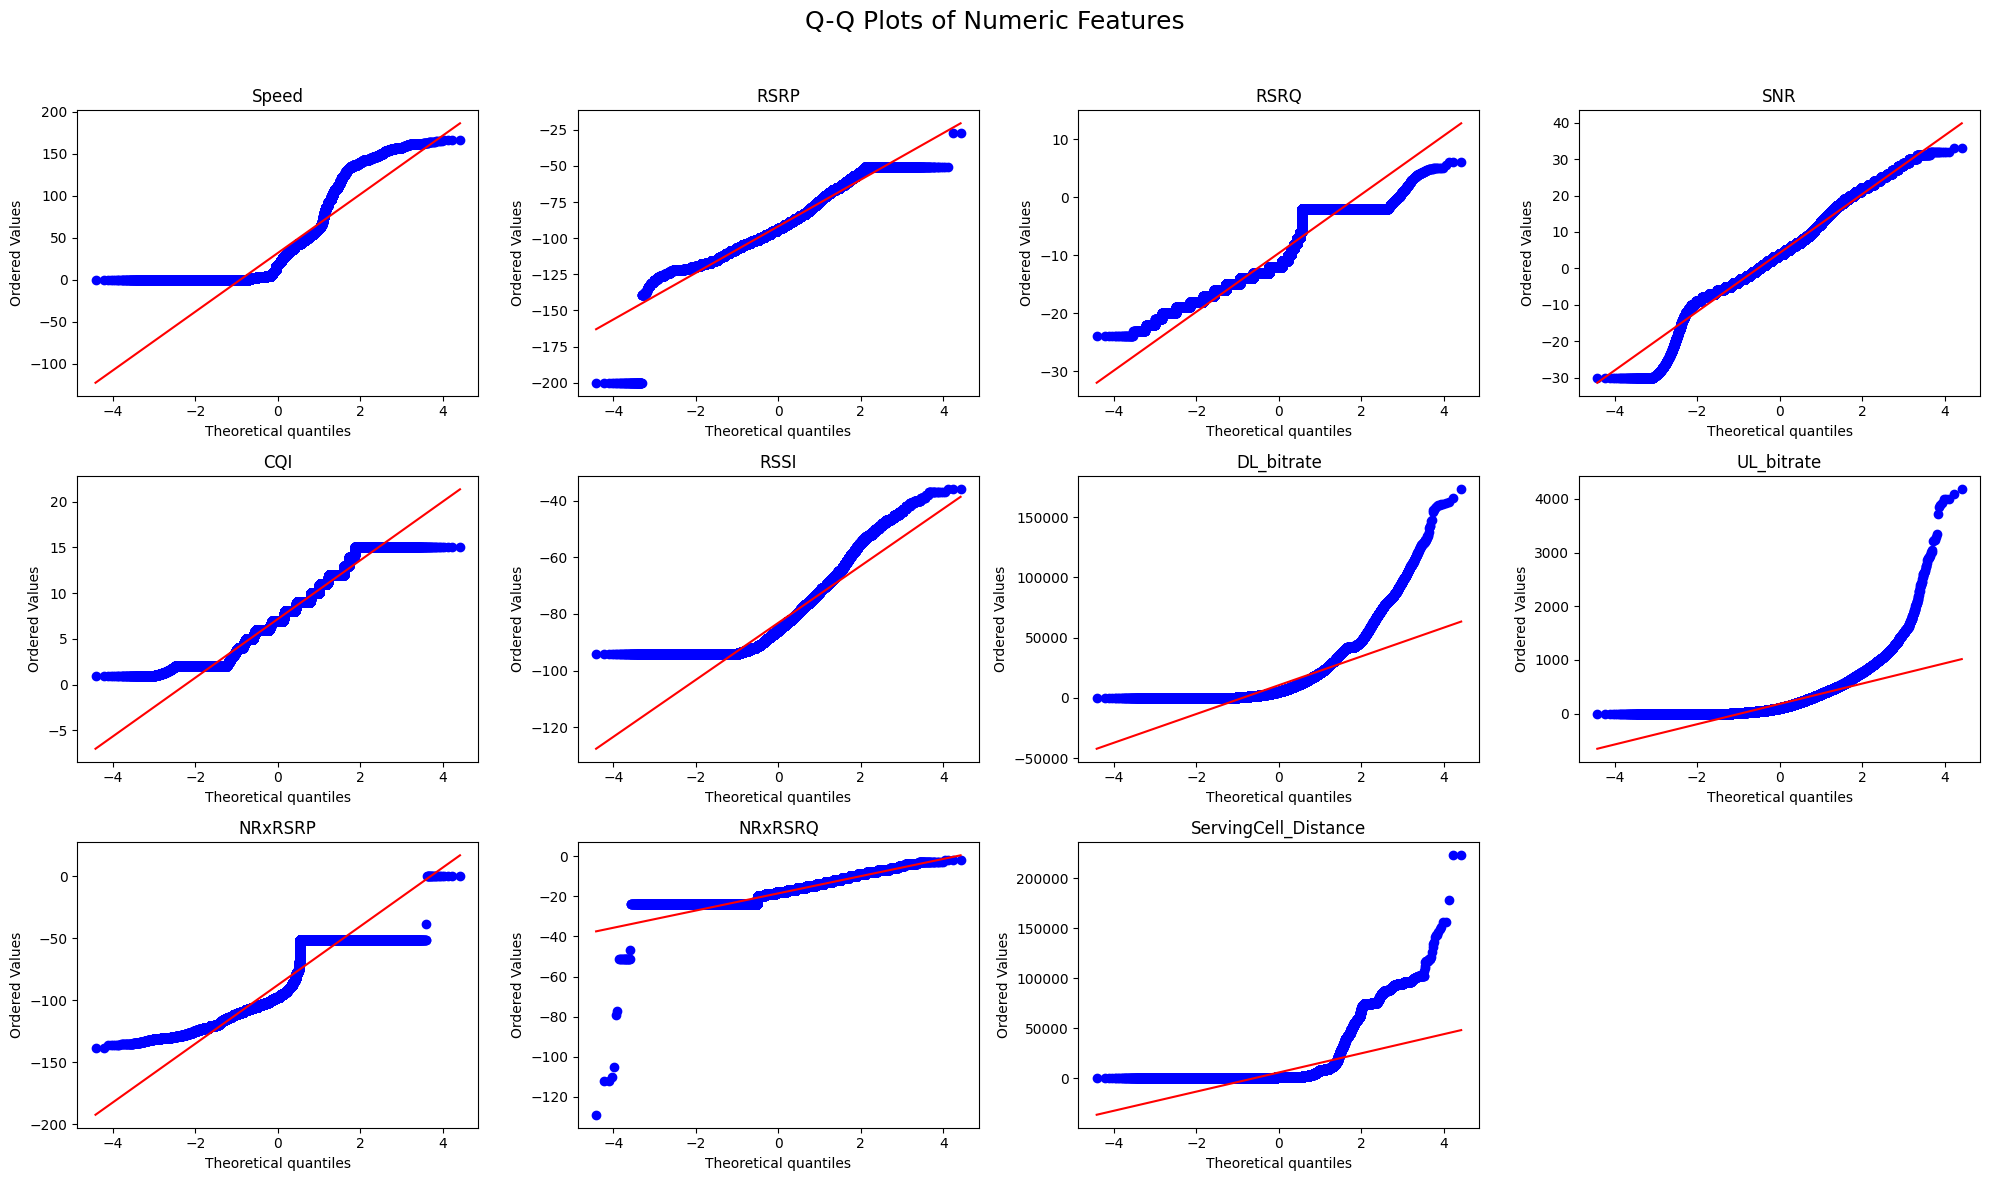

In [15]:
# Plot Q-Q plots for each feature
cols = 4
rows = math.ceil(len(numeric_columns) / cols)

fig, axes = plt.subplots(rows, cols, figsize=(20, rows * 4))
fig.suptitle("Q-Q Plots of Numeric Features", fontsize=18)
axes = axes.flatten()

for i, column in enumerate(numeric_columns):
    stats.probplot(train_df[column].dropna(), dist="norm", plot=axes[i])
    axes[i].set_title(f'{column}')

for i in range(len(numeric_columns), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

Since most features don't follow Normal Distribution, we detect the outliers using the IQR Method and apply capping to correct them.

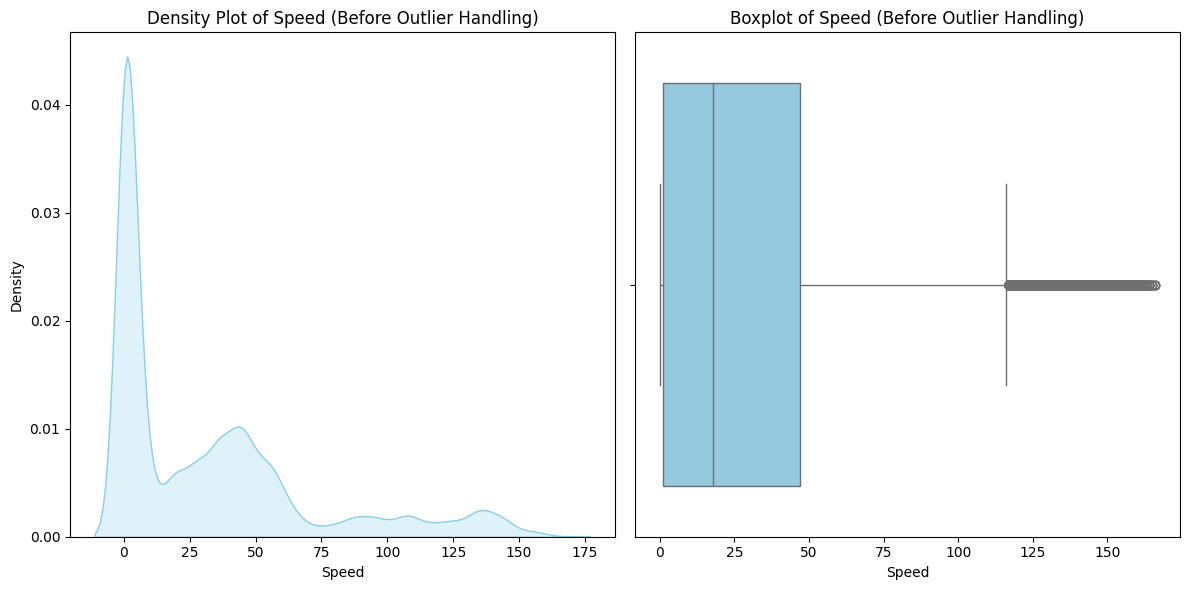

For column Speed:
Q1 = 1.0, Q3 = 47.0, IQR = 46.0
Lower Bound = -68.0, Upper Bound = 116.0
Number of Outliers: 8993



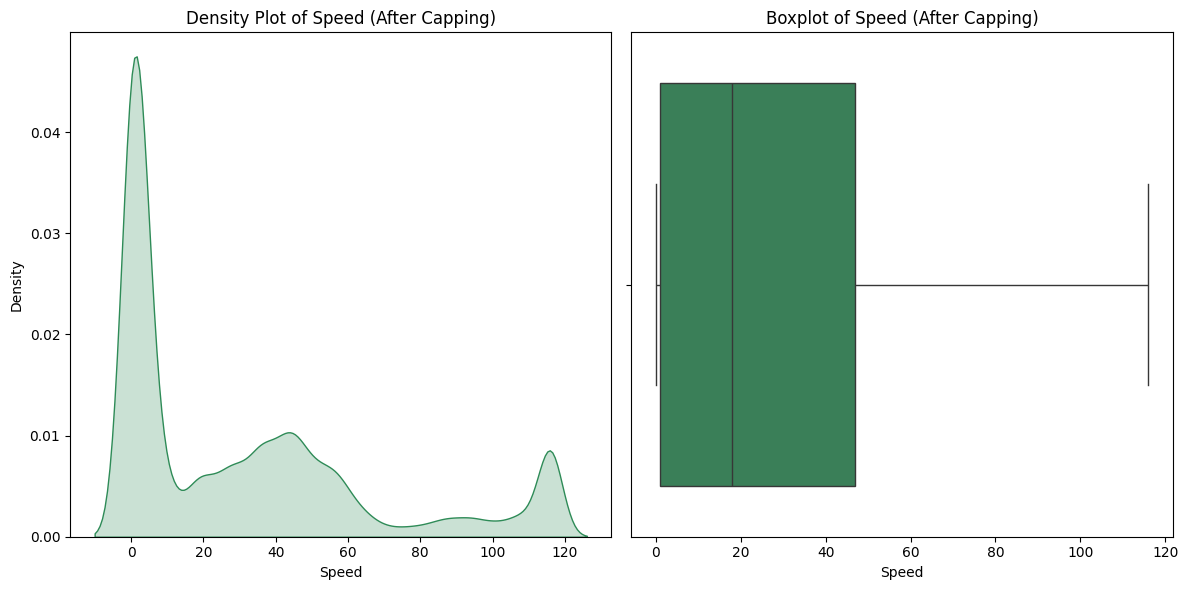

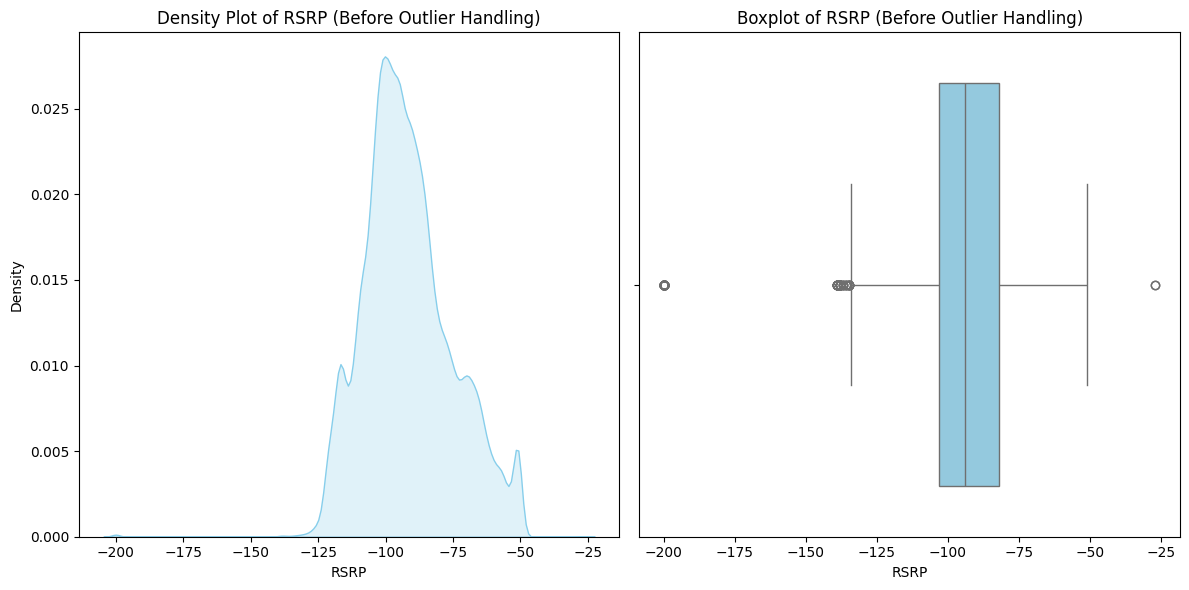

For column RSRP:
Q1 = -103.0, Q3 = -82.0, IQR = 21.0
Lower Bound = -134.5, Upper Bound = -50.5
Number of Outliers: 110



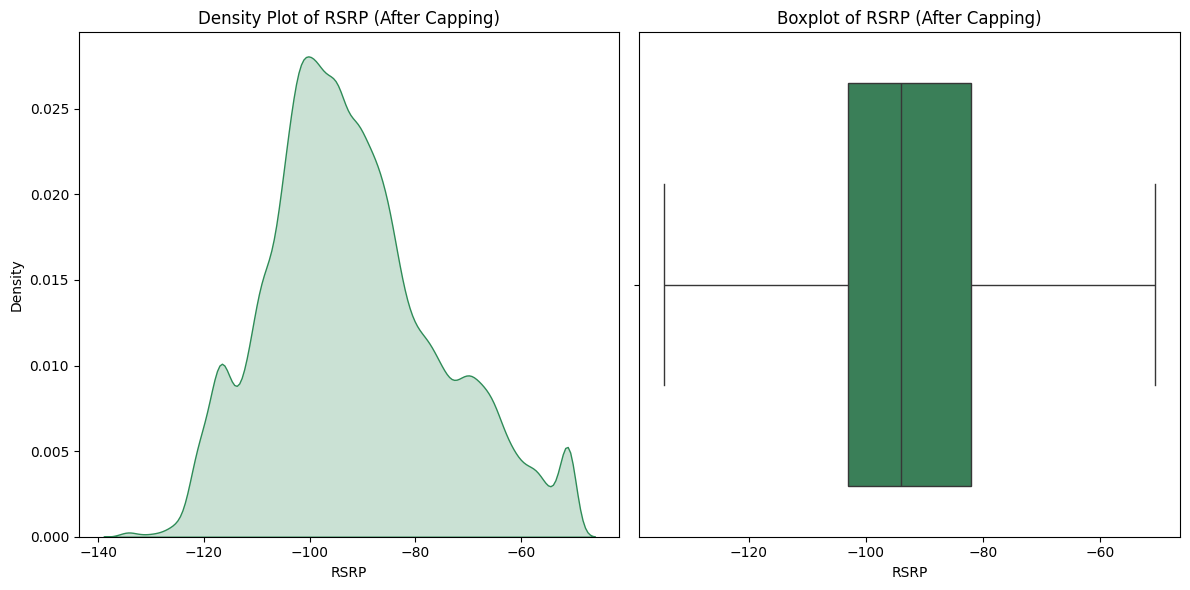

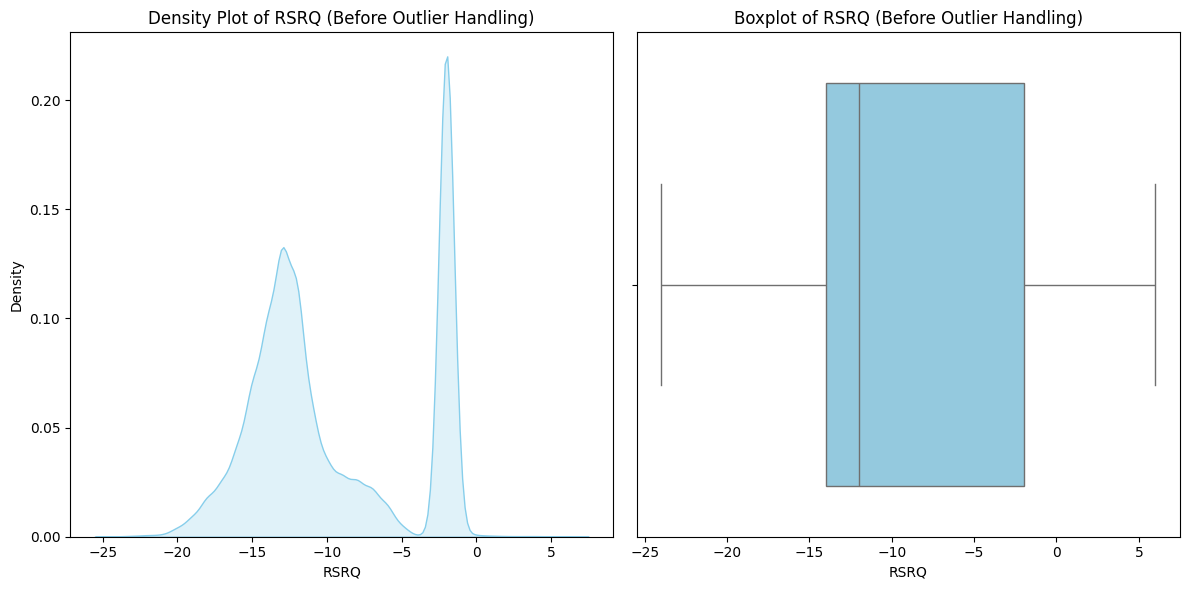

For column RSRQ:
Q1 = -14.0, Q3 = -2.0, IQR = 12.0
Lower Bound = -32.0, Upper Bound = 16.0
Number of Outliers: 0



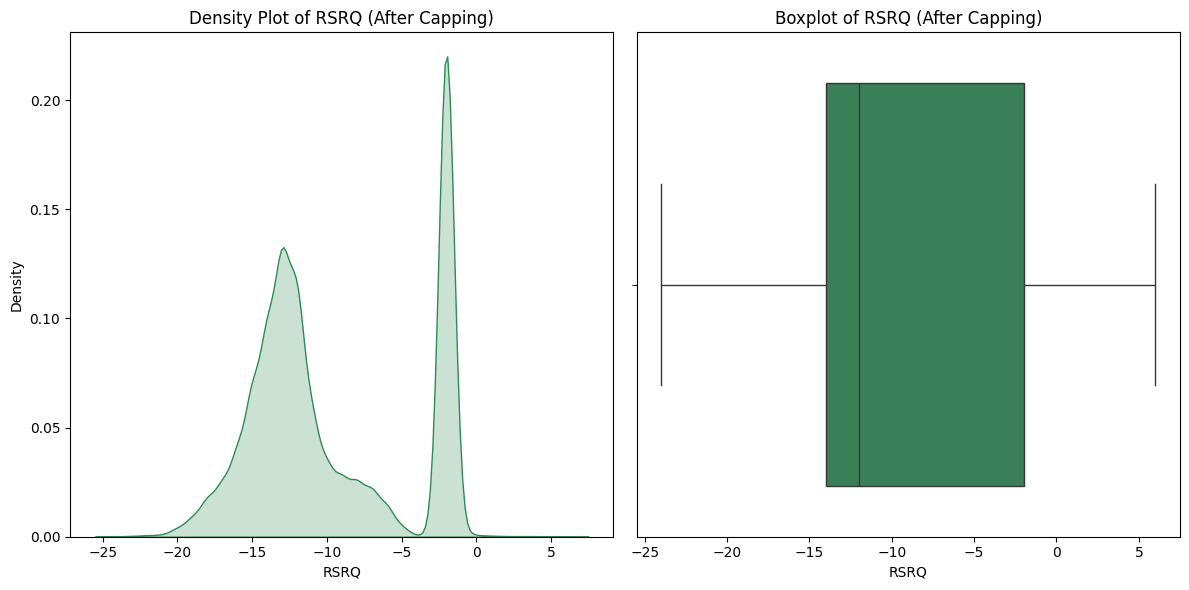

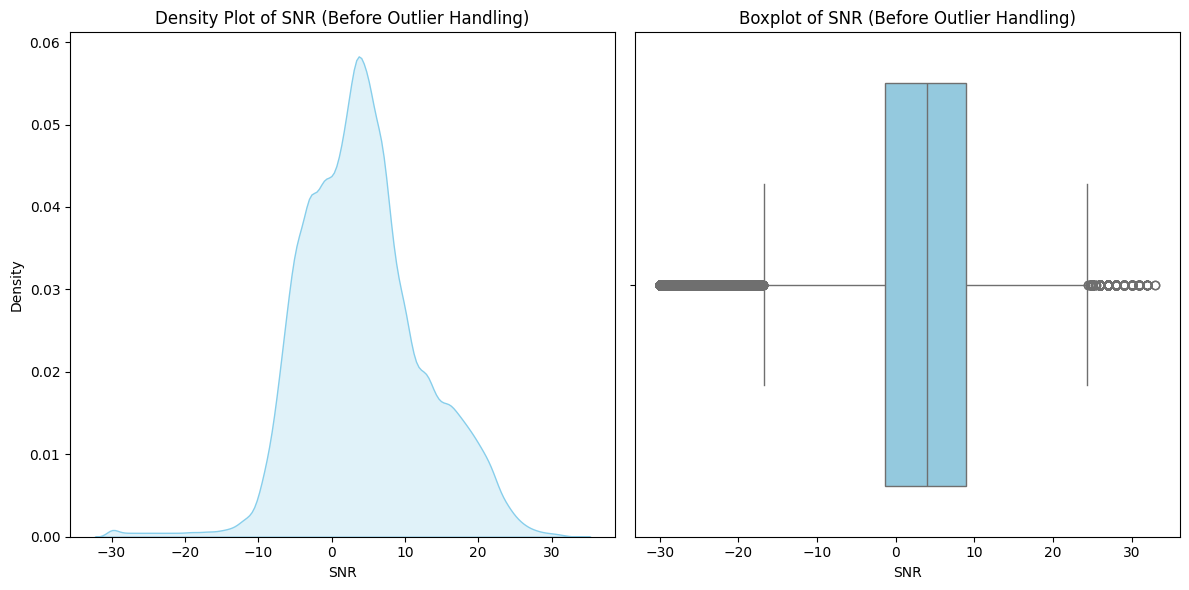

For column SNR:
Q1 = -1.3219448094612352, Q3 = 9.0, IQR = 10.321944809461236
Lower Bound = -16.80486202365309, Upper Bound = 24.482917214191854
Number of Outliers: 2077



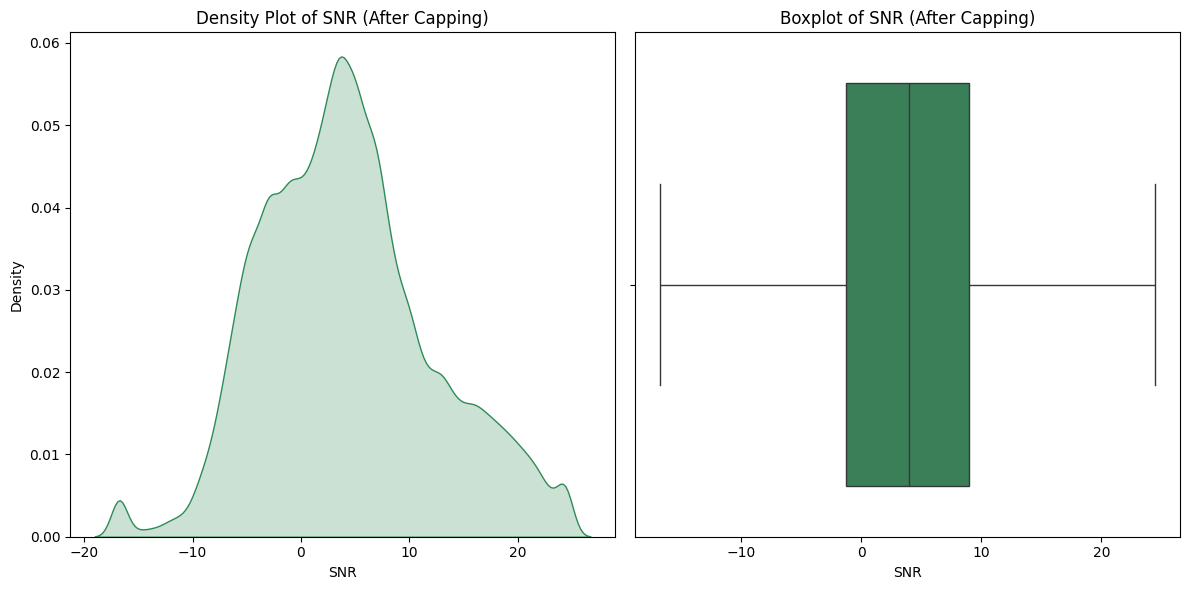

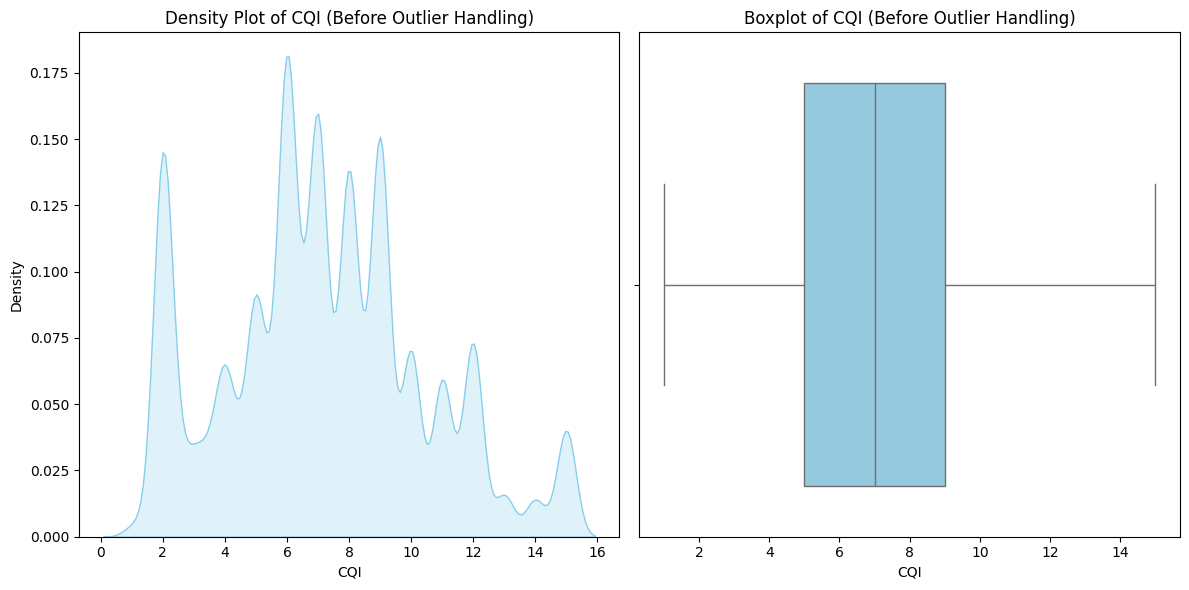

For column CQI:
Q1 = 5.0, Q3 = 9.0, IQR = 4.0
Lower Bound = -1.0, Upper Bound = 15.0
Number of Outliers: 0



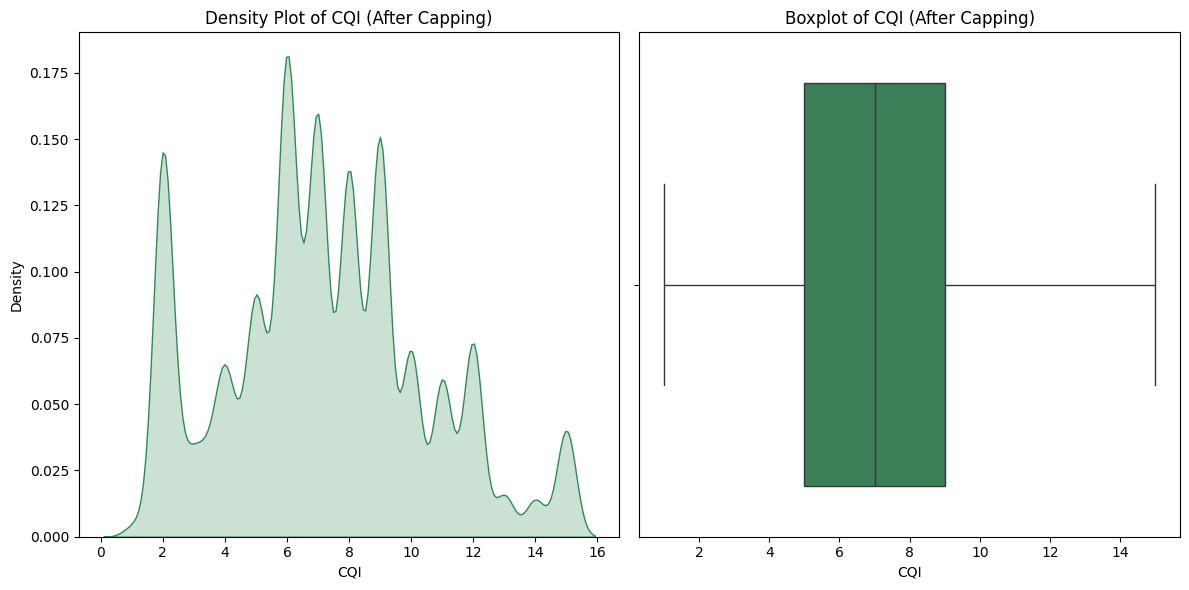

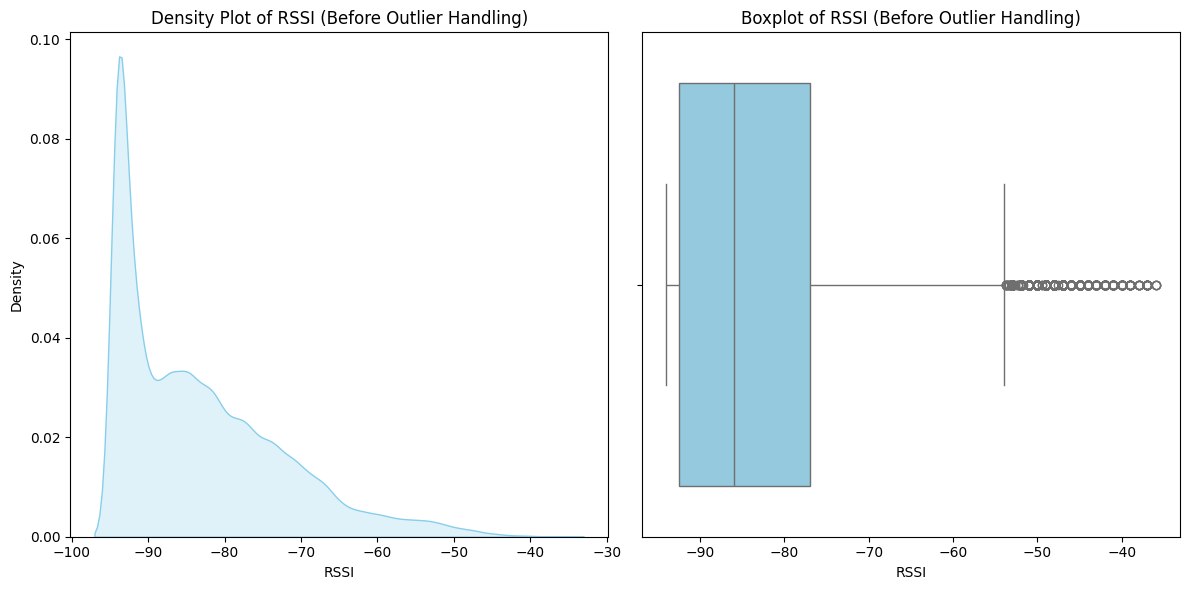

For column RSSI:
Q1 = -92.48327137546468, Q3 = -77.0, IQR = 15.483271375464682
Lower Bound = -115.7081784386617, Upper Bound = -53.77509293680298
Number of Outliers: 2490



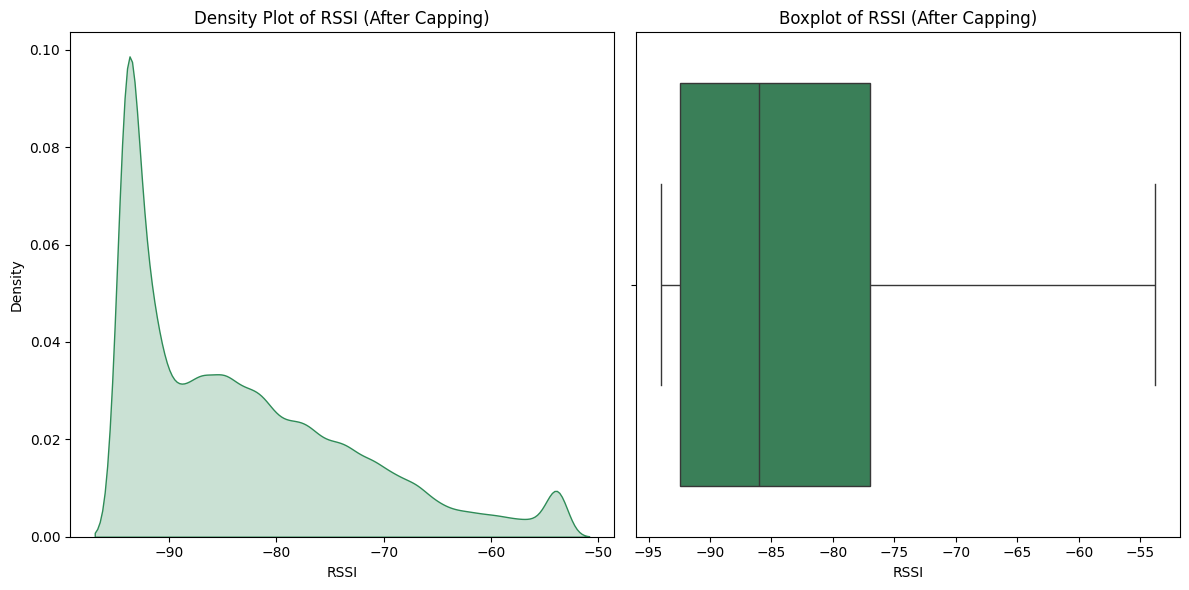

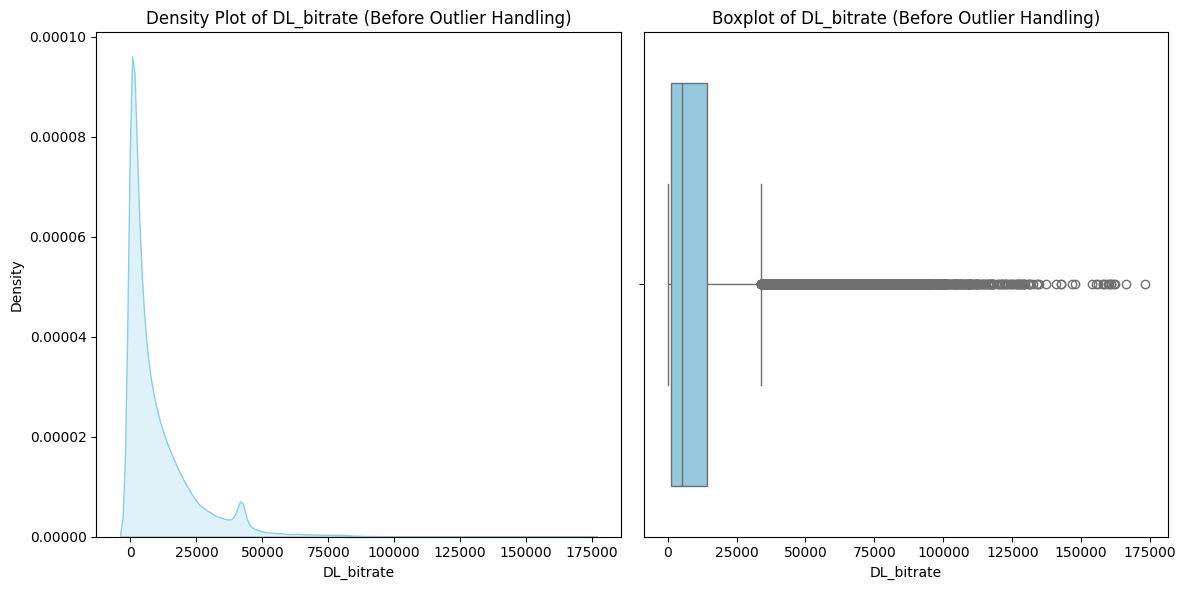

For column DL_bitrate:
Q1 = 1252.0, Q3 = 14360.0, IQR = 13108.0
Lower Bound = -18410.0, Upper Bound = 34022.0
Number of Outliers: 10614



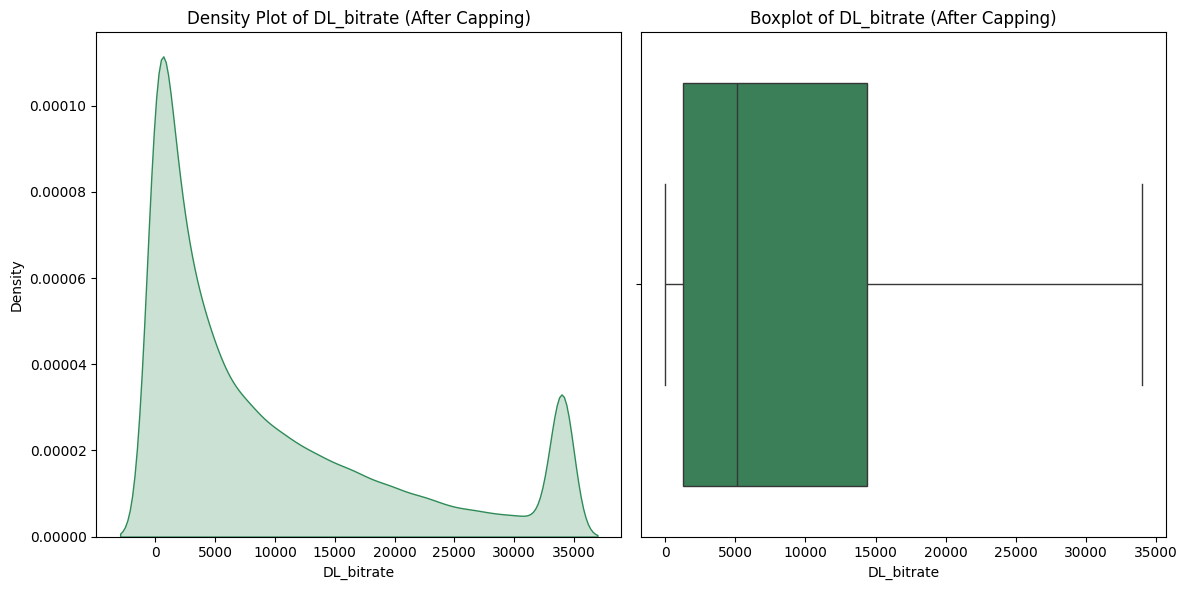

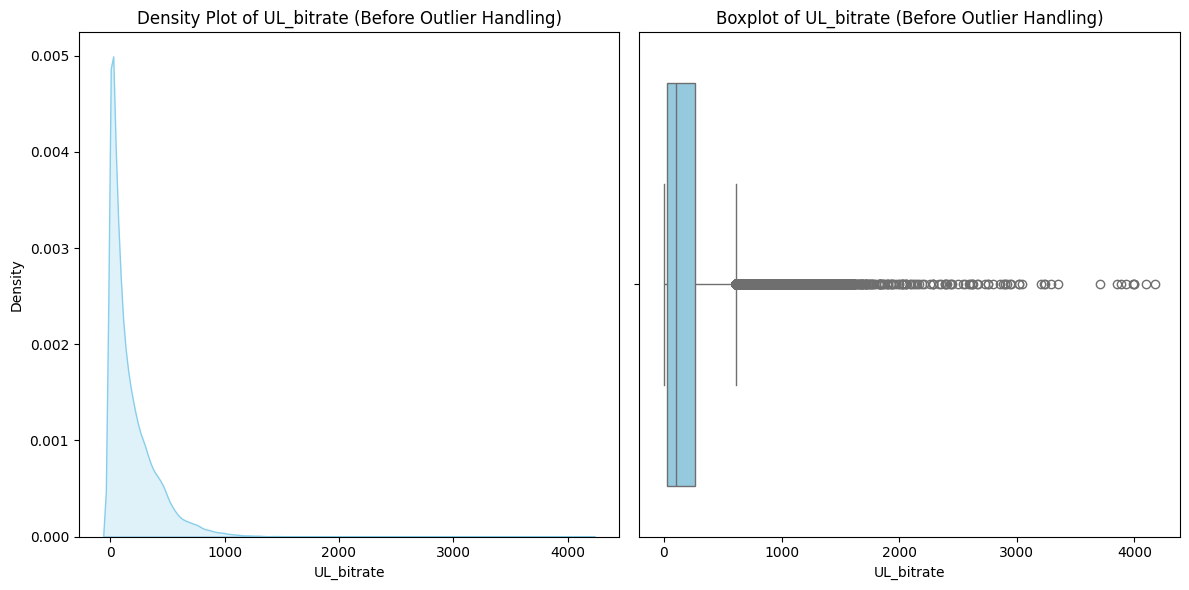

For column UL_bitrate:
Q1 = 29.0, Q3 = 262.0, IQR = 233.0
Lower Bound = -320.5, Upper Bound = 611.5
Number of Outliers: 6426



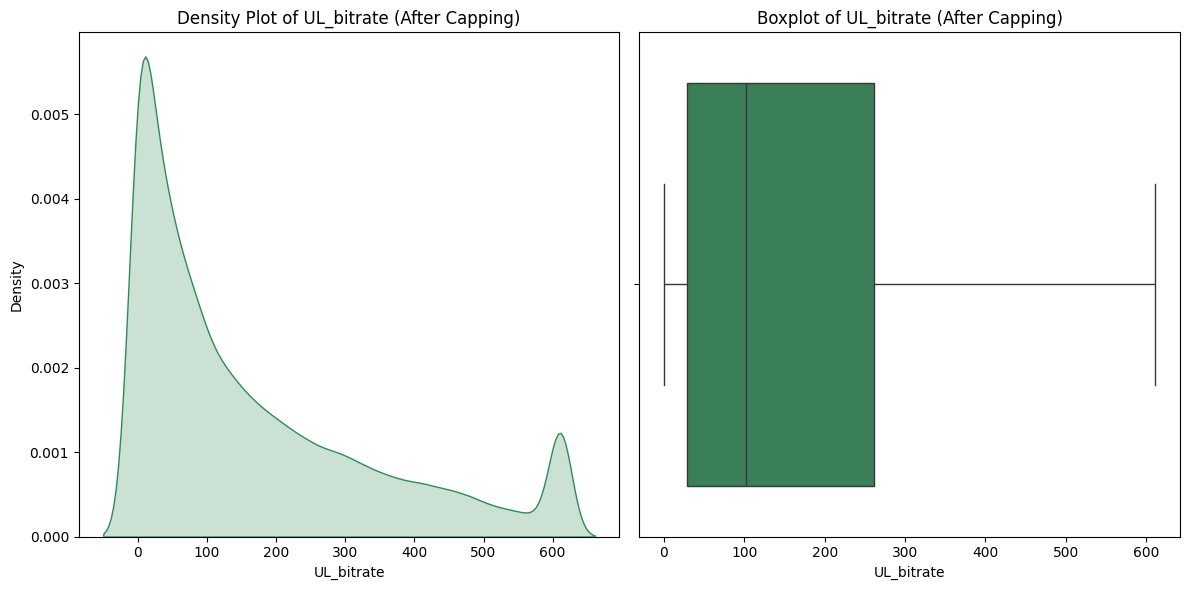

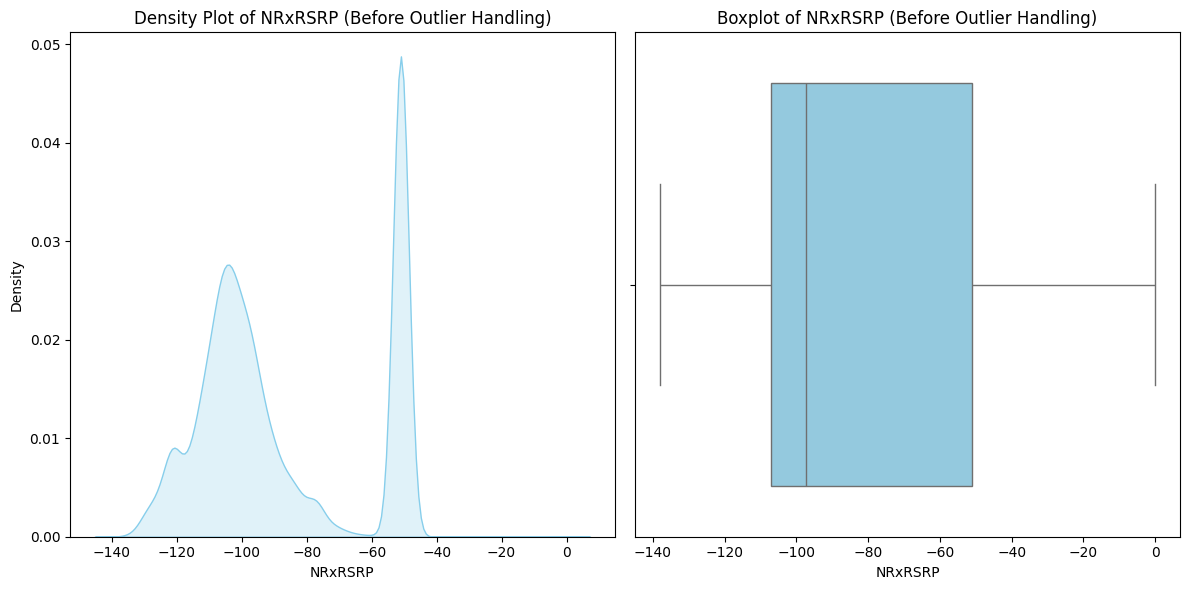

For column NRxRSRP:
Q1 = -107.0, Q3 = -51.0, IQR = 56.0
Lower Bound = -191.0, Upper Bound = 33.0
Number of Outliers: 0



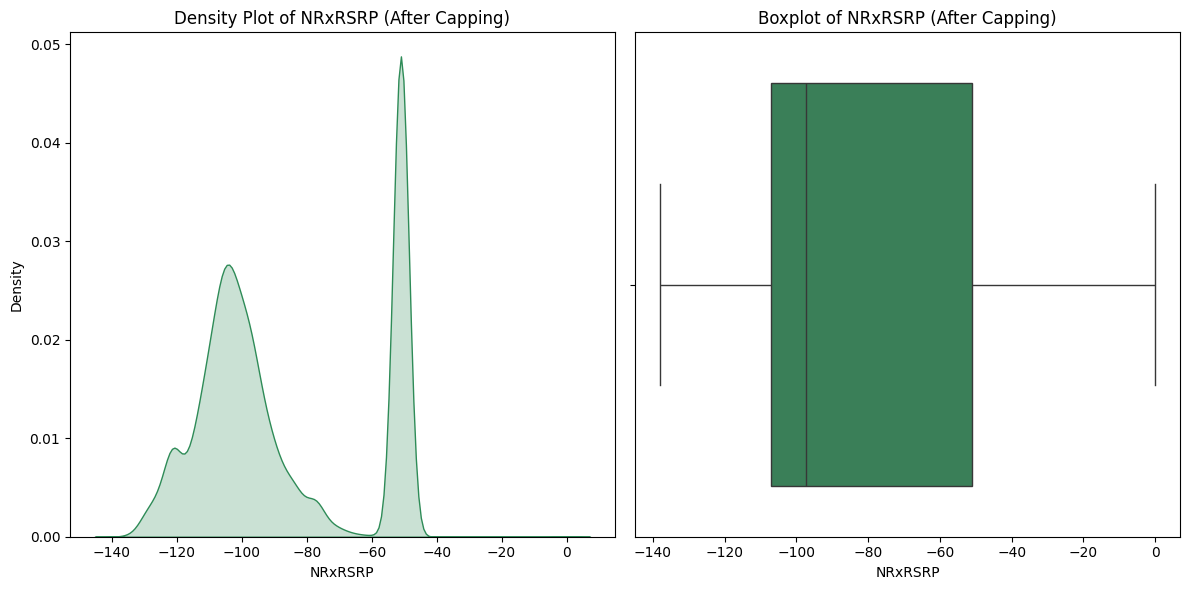

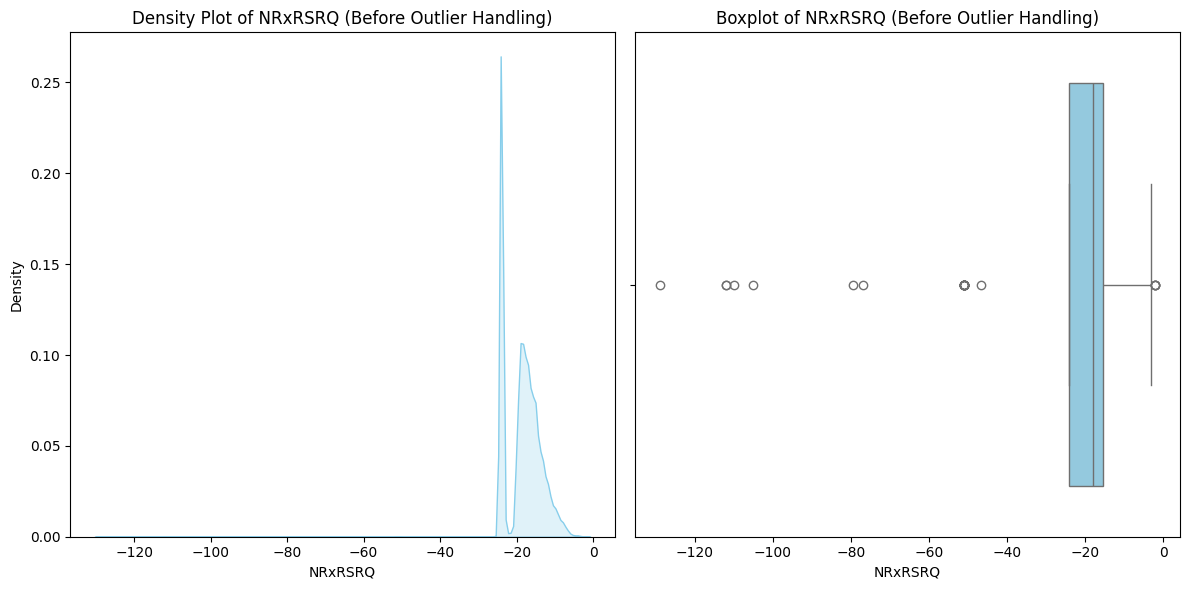

For column NRxRSRQ:
Q1 = -24.0, Q3 = -15.318181818181818, IQR = 8.681818181818182
Lower Bound = -37.02272727272727, Upper Bound = -2.295454545454545
Number of Outliers: 27



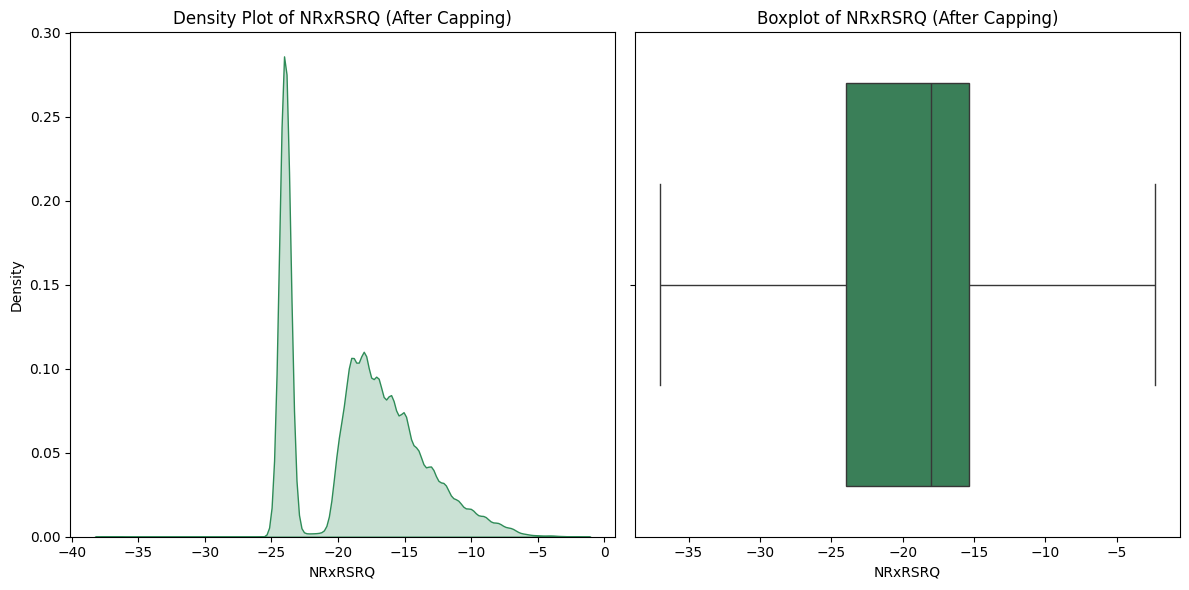

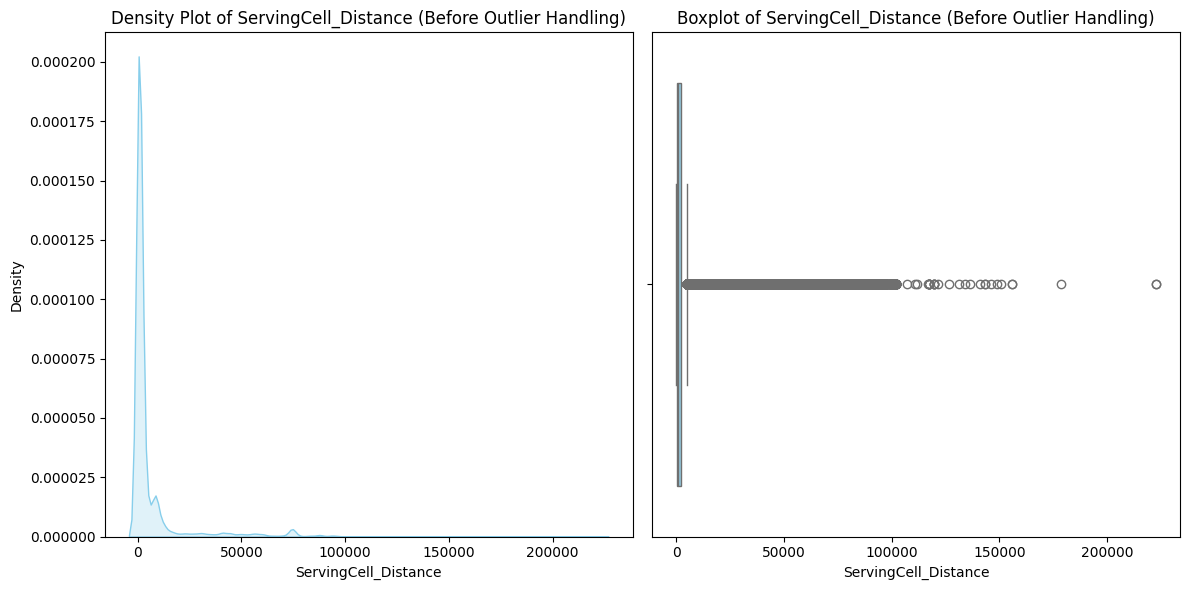

For column ServingCell_Distance:
Q1 = 524.4597196261682, Q3 = 2301.06, IQR = 1776.6002803738318
Lower Bound = -2140.4407009345796, Upper Bound = 4965.9604205607475
Number of Outliers: 25980



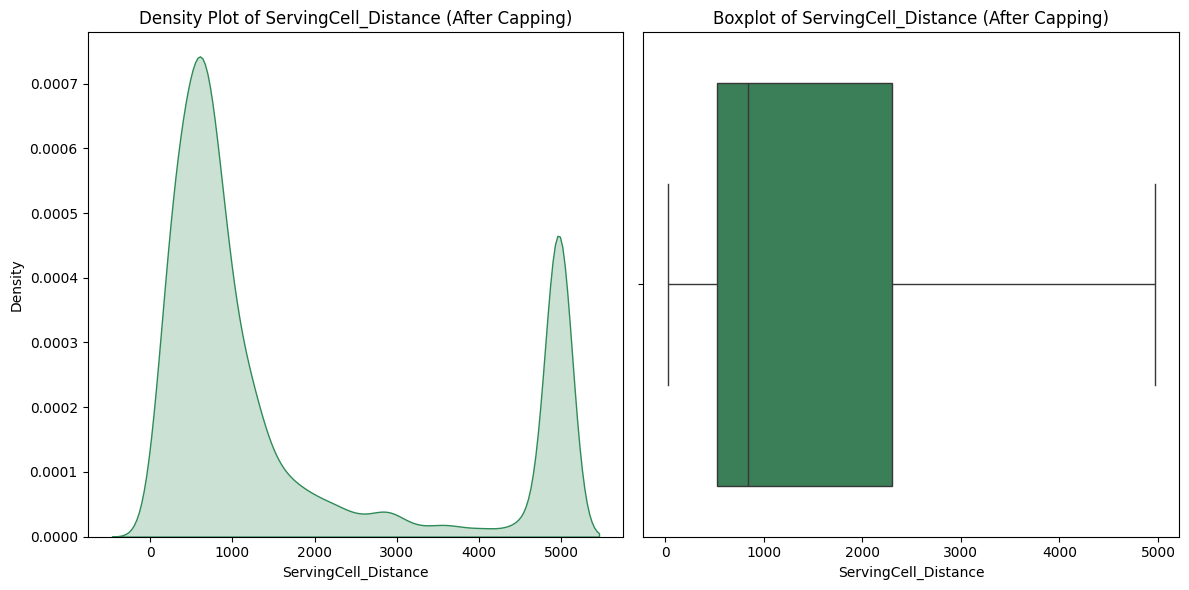

In [75]:
for column in numeric_columns:
    plt.figure(figsize=(12, 6))

    # Density Plot before capping the outliers
    plt.subplot(1, 2, 1)
    sns.kdeplot(train_df[column], fill=True, color="skyblue")
    plt.title(f'Density Plot of {column} (Before Outlier Handling)')
    plt.xlabel(column)

    # Boxplot before capping the outliers
    plt.subplot(1, 2, 2)
    sns.boxplot(x=train_df[column], color="skyblue")
    plt.title(f'Boxplot of {column} (Before Outlier Handling)')
    plt.xlabel(column)

    plt.tight_layout()
    plt.show()

    # Locate outliers based on IQR
    Q1 = np.percentile(train_df[column].dropna(), 25)
    Q3 = np.percentile(train_df[column].dropna(), 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR  # Use 1.5 * IQR as boundaries
    upper_bound = Q3 + 1.5 * IQR

    print(f"For column {column}:")
    print(f"Q1 = {Q1}, Q3 = {Q3}, IQR = {IQR}")
    print(f"Lower Bound = {lower_bound}, Upper Bound = {upper_bound}")
    outliers = train_df[(train_df[column] < lower_bound) | (train_df[column] > upper_bound)]
    print(f"Number of Outliers: {len(outliers)}")
    print()

    # Cap the outliers
    train_df[column] = np.where(train_df[column] < lower_bound, lower_bound, train_df[column])
    train_df[column] = np.where(train_df[column] > upper_bound, upper_bound, train_df[column])

    plt.figure(figsize=(12, 6))

    # Density Plot after capping
    plt.subplot(1, 2, 1)
    sns.kdeplot(train_df[column], fill=True, color="seagreen")
    plt.title(f'Density Plot of {column} (After Capping)')
    plt.xlabel(column)

    # Boxplot after capping
    plt.subplot(1, 2, 2)
    sns.boxplot(x=train_df[column], color="seagreen")
    plt.title(f'Boxplot of {column} (After Capping)')
    plt.xlabel(column)

    plt.tight_layout()
    plt.show()

Finally, we compute the correlation matrix to see how the numerical features are related with each other.

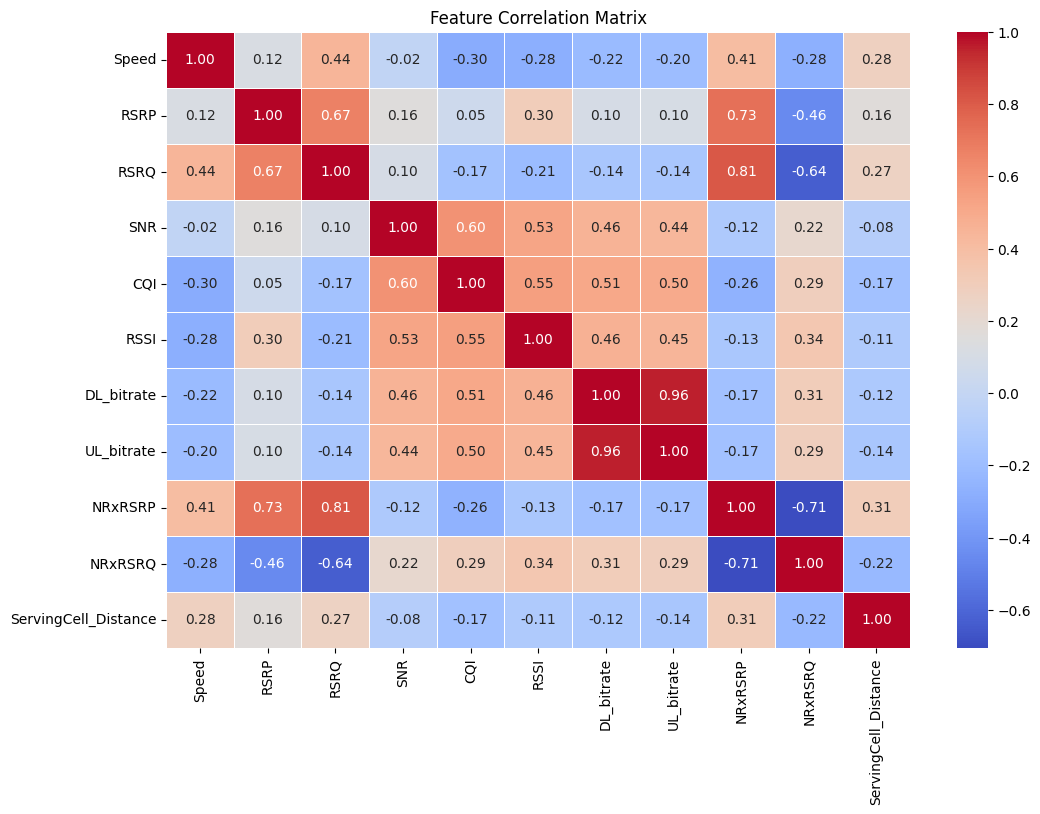

In [57]:
# Compute the correlation matrix using Pearson coefficient
correlation_matrix = train_df[numeric_columns].corr(method='pearson')

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, cmap="coolwarm", annot=True, fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Matrix")
plt.show()

## **Categorical features**

We combine all the categorical features in one numerical feature called "Categorical_Impact" using the principal component with the biggest variance from PCA Analysis.

In [76]:
# Define categorical features
categorical_features = ["State", "NetworkMode", "Operatorname", "CellID", "scenario"]

# Fit OneHotEncoder on training and test sets
encoder = OneHotEncoder(drop='first', handle_unknown='ignore')
encoded_train = encoder.fit_transform(train_df[categorical_features])
encoded_test = encoder.transform(test_df[categorical_features])

# Fit PCA on encoded training and test sets
pca = PCA(n_components=1)
train_df["Categorical_Impact"] = pca.fit_transform(encoded_train)
test_df["Categorical_Impact"] = pca.transform(encoded_test)

# Drop original categorical columns
train_df.drop(columns=categorical_features, inplace=True)
test_df.drop(columns=categorical_features, inplace=True)

In [77]:
train_df

,Timestamp,Speed,RSRP,RSRQ,SNR,CQI,RSSI,DL_bitrate,UL_bitrate,NRxRSRP,NRxRSRQ,ServingCell_Distance,Categorical_Impact
0,2017-11-21 15:03:50,0.0,-95.0,-13.0,4.0,10.0,-80.0,0.0,0.0,-106.0,-19.0,551.370000,0.758840
1,2017-11-21 15:03:51,0.0,-95.0,-13.0,2.0,8.0,-78.0,0.0,0.0,-106.0,-19.0,551.370000,0.599827
2,2017-11-21 15:03:52,0.0,-95.0,-13.0,13.0,9.0,-80.0,0.0,0.0,-106.0,-19.0,553.430000,0.599827
3,2017-11-21 15:03:53,1.0,-95.0,-13.0,13.0,9.0,-80.0,0.0,0.0,-106.0,-19.0,563.480000,0.599827
4,2017-11-21 15:03:54,1.0,-97.0,-13.0,-2.0,9.0,-80.0,0.0,0.0,-106.0,-19.0,563.480000,0.599827
...,...,...,...,...,...,...,...,...,...,...,...,...,...
138948,2018-01-18 15:03:26,0.0,-95.0,-14.0,-5.0,8.0,-88.0,6811.0,103.0,-98.0,-19.0,2911.320000,0.581546
138949,2018-01-18 15:03:26,46.0,-104.0,-15.0,-2.0,7.0,-88.0,14337.0,216.0,-107.0,-16.0,4965.960421,0.784428
138950,2018-01-18 15:03:27,0.0,-95.0,-14.0,-5.0,8.0,-88.0,8443.0,142.0,-98.0,-19.0,2911.320000,0.581546
138951,2018-01-18 15:03:28,46.0,-104.0,-15.0,-2.0,7.0,-88.0,15378.0,256.0,-107.0,-16.0,4965.960421,0.784428


Apply MinMax Scaling and handle the scale differences between DL_bitrate, UL_bitrate and the other features by applying log transform.

In [78]:
train_df.drop(columns=['Timestamp'], inplace=True)
test_df.drop(columns=['Timestamp'], inplace=True)

# Apply log1p to avoid undefined log(0)
train_df["DL_bitrate"] = np.log1p(train_df["DL_bitrate"])
train_df["UL_bitrate"] = np.log1p(train_df["UL_bitrate"])

test_df["DL_bitrate"] = np.log1p(test_df["DL_bitrate"])
test_df["UL_bitrate"] = np.log1p(test_df["UL_bitrate"])

# Fit MinMaxScaler on;y on training set
scaler = MinMaxScaler()
train_df = scaler.fit_transform(train_df)

# Transform test set using the same scaler
test_df = scaler.transform(test_df)

In [79]:
# Convert back to DataFrame to retain structure
train_df = pd.DataFrame(train_df, columns=['Speed',	'RSRP',	'RSRQ',	'SNR', 'CQI',	'RSSI',	'DL_bitrate',	'UL_bitrate',	'NRxRSRP',	'NRxRSRQ',	'ServingCell_Distance',	'Categorical_Impact'])
test_df = pd.DataFrame(test_df, columns=['Speed',	'RSRP',	'RSRQ',	'SNR', 'CQI',	'RSSI',	'DL_bitrate',	'UL_bitrate',	'NRxRSRP',	'NRxRSRQ',	'ServingCell_Distance',	'Categorical_Impact'])

In [80]:
train_df

,Speed,RSRP,RSRQ,SNR,CQI,RSSI,DL_bitrate,UL_bitrate,NRxRSRP,NRxRSRQ,ServingCell_Distance,Categorical_Impact
0,0.000000,0.470238,0.366667,0.503899,0.642857,0.348043,0.000000,0.000000,0.231884,0.518979,0.106456,0.919429
1,0.000000,0.470238,0.366667,0.455458,0.500000,0.397764,0.000000,0.000000,0.231884,0.518979,0.106456,0.856280
2,0.000000,0.470238,0.366667,0.721881,0.571429,0.348043,0.000000,0.000000,0.231884,0.518979,0.106873,0.856280
3,0.008621,0.470238,0.366667,0.721881,0.571429,0.348043,0.000000,0.000000,0.231884,0.518979,0.108907,0.856280
4,0.008621,0.446429,0.366667,0.358577,0.571429,0.348043,0.000000,0.000000,0.231884,0.518979,0.108907,0.856280
...,...,...,...,...,...,...,...,...,...,...,...,...
138948,0.000000,0.470238,0.333333,0.285917,0.500000,0.149161,0.845867,0.723702,0.289855,0.518979,0.584126,0.849019
138949,0.396552,0.363095,0.300000,0.358577,0.428571,0.149161,0.917188,0.838310,0.224638,0.605366,1.000000,0.929591
138950,0.000000,0.470238,0.333333,0.285917,0.500000,0.149161,0.866449,0.773324,0.289855,0.518979,0.584126,0.849019
138951,0.396552,0.363095,0.300000,0.358577,0.428571,0.149161,0.923905,0.864672,0.224638,0.605366,1.000000,0.929591


Finally, save the processed training and test sets that will be used for the training and the evaluation of the 2 models later.

In [82]:
# Save training and test sets into csv files
train_df.to_csv("/content/drive/MyDrive/training_set.csv", index=False)
test_df.to_csv("/content/drive/MyDrive/test_set.csv", index=False)